# Income Classification
The goal of this project is to develop an accurate and robust classifier that predicts whether an individual's income exceeds $50,000 based on demographic and work-related features from census data. 

# Part III. Pipeline testing

**Key objectives:**
- Train the final model using the best parameters
- Analyse, explore, and save results 
- Prepare the solution for further deployment and monitoring

## Table of Contents
    1. Data cleaning and preprocessing
    2. Train CatBoost model using tuned parameters
    3. Model Interpretation using Feature Importance & SHAP
    4. Integration of the pipeline for reuse and production


In [1]:
import pandas as pd
import yaml
import json

from src.model import CatBoostPipeline 
from utils.preprocessing import preprocess_data

# 1. Load Data & Preprocess

We apply the full preprocessing pipeline on the raw data.

---

*The pipeline is modular and commented for clarity. All assumptions and methodological choices are justified throughout the notebook.*

In [2]:
# Import data configuration file
with open("utils/data_config.yml", "r") as f:
    config = yaml.safe_load(f)

# Read train and test data
train_df = pd.read_csv("data/census_income_learn.csv", header=None)
test_df = pd.read_csv("data/census_income_test.csv", header=None)

# Preprocess and transform data
X_train, X_test, y_train, y_test, cat_features = preprocess_data(
    train_df, test_df,
    config=config
)

✅ Preprocessing ended successfully.


#  2. Train CatBoost model using tuned parameters

We apply the full preprocessing pipeline on the raw data

In [3]:
# Instantiate pipeline model
pipe = CatBoostPipeline(config_path="config.yml")

# Train model
pipe.fit(X_train, y_train)

# Save model and features
pipe.save()

# Evaluation on test data
report = pipe.evaluate(X_test, y_test, save_report=True)

[CatBoostPipeline] Pipeline initialized with config: config.yml
[CatBoostPipeline] Start training CatBoost model...
0:	learn: 0.6142987	total: 379ms	remaining: 3m 9s
100:	learn: 0.2828815	total: 18.2s	remaining: 1m 11s
200:	learn: 0.2351145	total: 38.6s	remaining: 57.5s
300:	learn: 0.2040944	total: 1m 1s	remaining: 40.8s
400:	learn: 0.1796677	total: 1m 25s	remaining: 21s
499:	learn: 0.1620245	total: 1m 48s	remaining: 0us
[CatBoostPipeline] Model training complete.
[CatBoostPipeline] Model saved to models/catboost_final.cbm
[CatBoostPipeline] Features saved to models/features_final.pkl
[CatBoostPipeline] Report saved to reports/final_metrics.json


In [14]:
# Classification report
print("Classification report (test set):")
print(json.dumps(report, indent=2))

Classification report (test set):
{
  "0": {
    "precision": 0.9855042851467166,
    "recall": 0.9277806275113277,
    "f1-score": 0.9557716971888744,
    "support": 93576.0
  },
  "1": {
    "precision": 0.4207594068740893,
    "recall": 0.793566117038474,
    "f1-score": 0.5499355850557329,
    "support": 6186.0
  },
  "accuracy": 0.9194583107796556,
  "macro avg": {
    "precision": 0.703131846010403,
    "recall": 0.8606733722749009,
    "f1-score": 0.7528536411223037,
    "support": 99762.0
  },
  "weighted avg": {
    "precision": 0.9504858230369506,
    "recall": 0.9194583107796556,
    "f1-score": 0.9306067827960635,
    "support": 99762.0
  },
  "model_path": "models/catboost_final.cbm",
  "features_path": "models/features_final.pkl",
  "params": {
    "task_type": "CPU",
    "devices": "0",
    "auto_class_weights": "Balanced",
    "iterations": 500,
    "depth": 10,
    "learning_rate": 0.1,
    "random_state": 42,
    "l2_leaf_reg": 1,
    "verbose": -1
  }
}


In [3]:
# Load from saved model and predict 
pipe = CatBoostPipeline(config_path="config.yml")
pipe.load()
y_pred = pipe.predict(X_test)
print("Example predictions:", y_pred[:10])

[CatBoostPipeline] Pipeline initialized with config: config.yml
[CatBoostPipeline] Model and features loaded from models/catboost_final.cbm and models/features_final.pkl
Example predictions: [0 0 0 0 0 0 0 0 0 0]


# 3. Model Interpretation using Feature Importance & SHAP


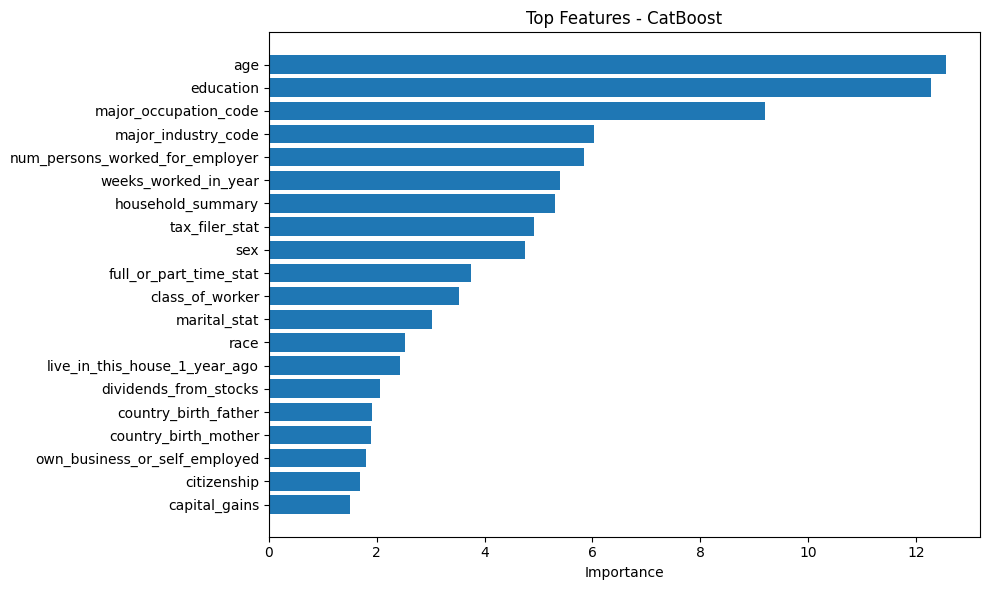

In [24]:
from utils.evaluation import plot_feature_importance, shap_summary, shap_waterfall_plot

plot_feature_importance(
    pipe.model, pipe.feature_names, top_n=20, model_name="CatBoost"
)

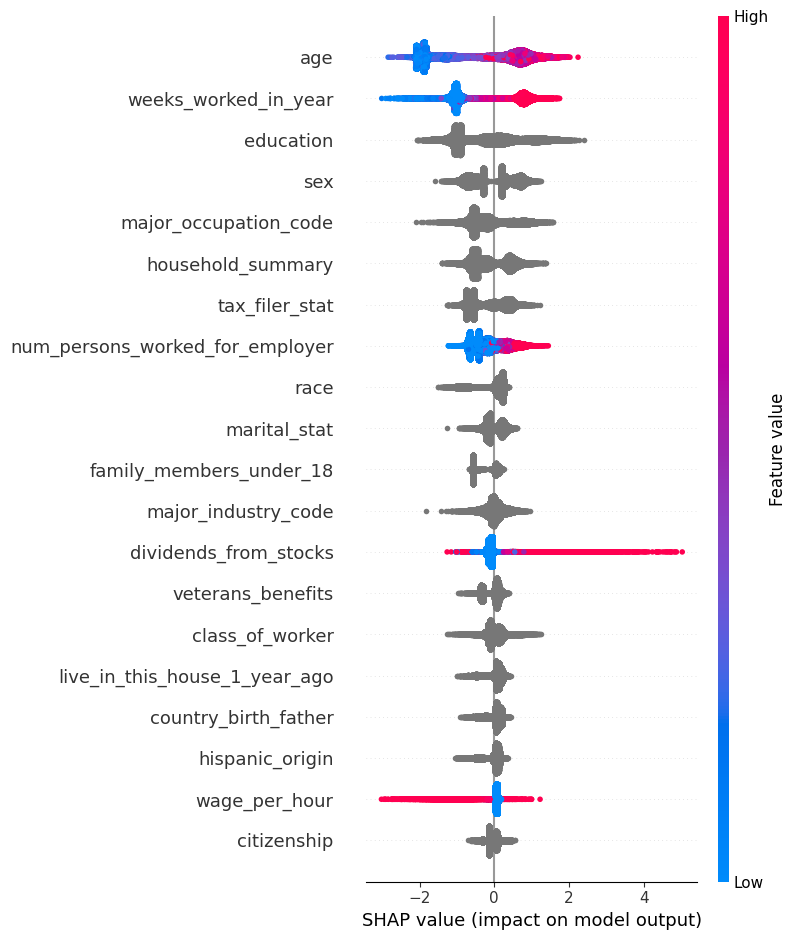

In [27]:
shap_values = shap_summary(
    pipe.model, X_test, model_type="tree"
)

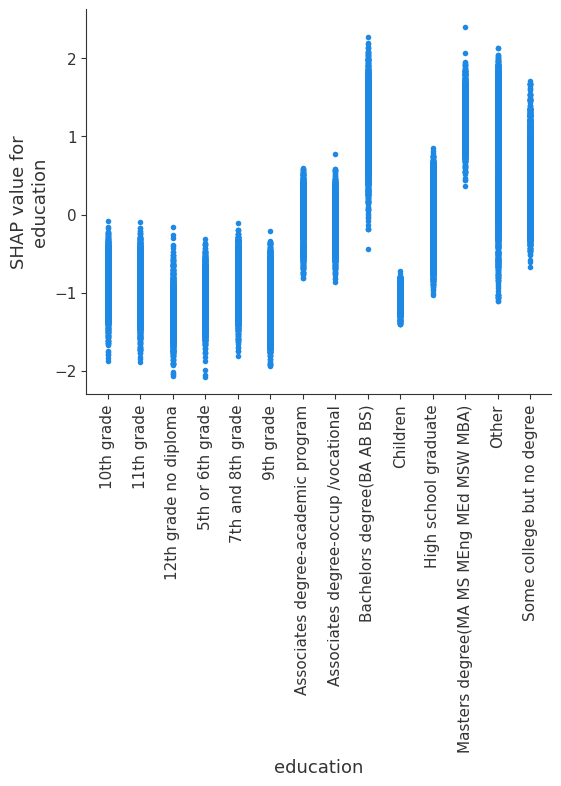

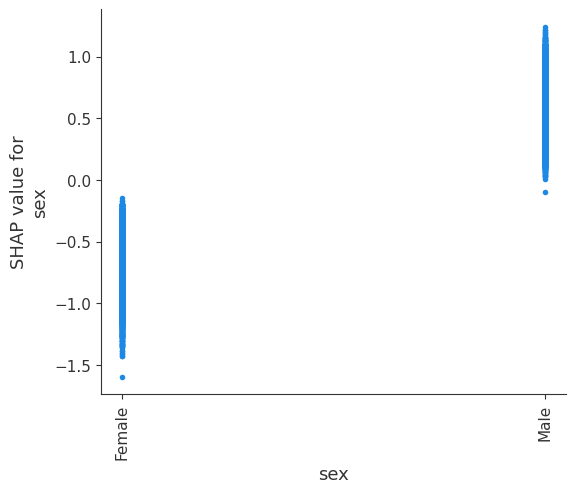

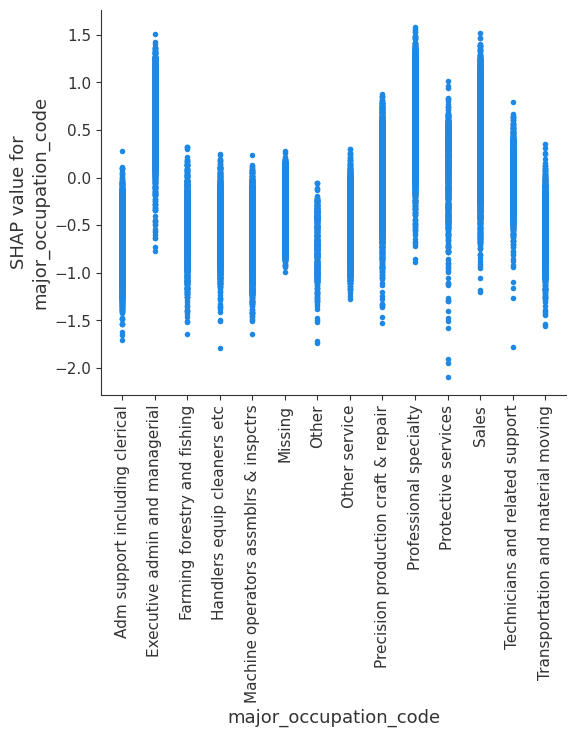

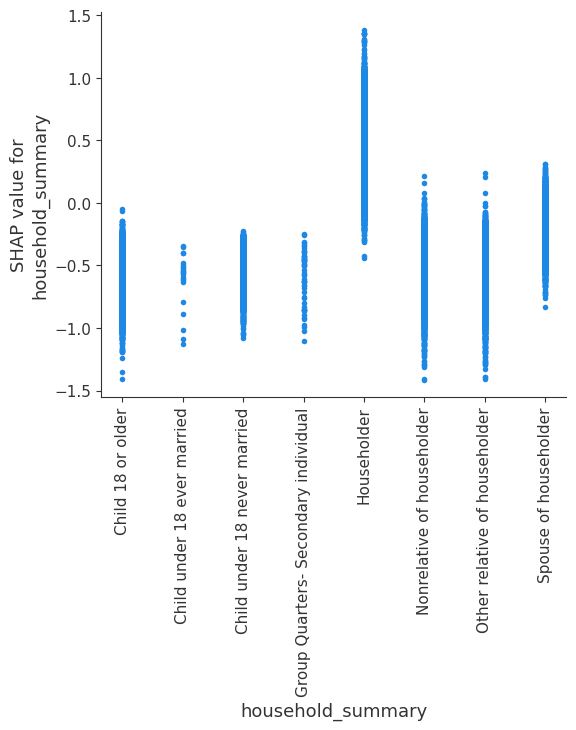

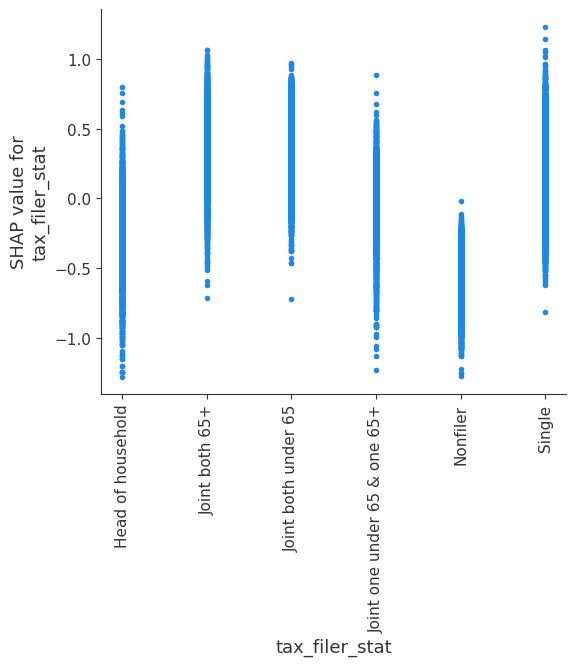

In [35]:
shap.dependence_plot("education", shap_values.values, X_test, interaction_index=None)
shap.dependence_plot("sex", shap_values.values, X_test, interaction_index=None)
shap.dependence_plot("major_occupation_code", shap_values.values, X_test, interaction_index=None)
shap.dependence_plot("household_summary", shap_values.values, X_test, interaction_index=None)
shap.dependence_plot("tax_filer_stat", shap_values.values, X_test, interaction_index=None)

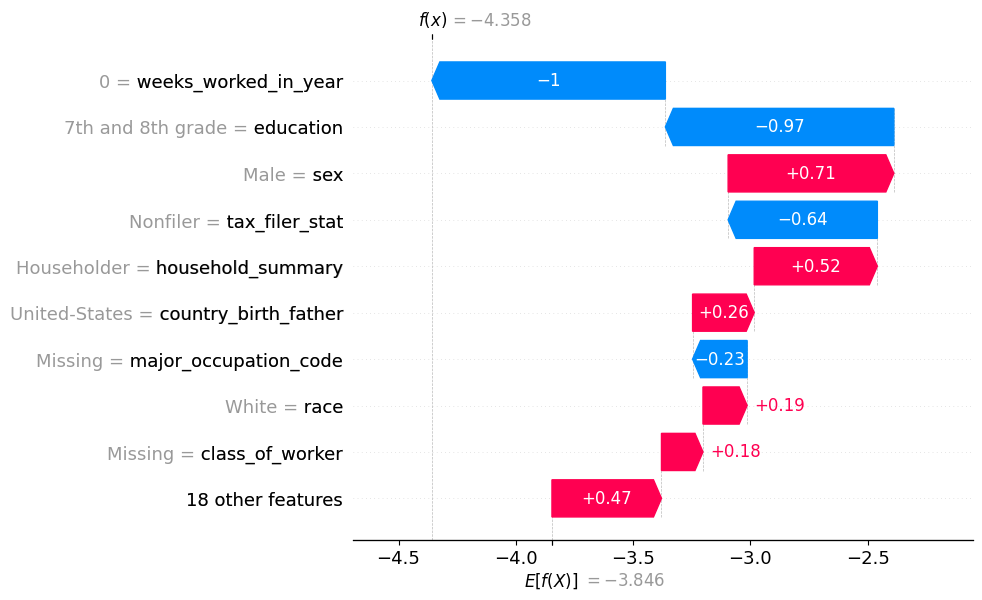

In [12]:
# Local explanation for one individual
shap_waterfall_plot(shap_values, row_idx=40)
